In [25]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import listdir
import cv2
import math
from collections import Counter
# from sklearn import preprocessing
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn import metrics

In [9]:
# Function that calculates proportion of sum of all windows' widths (on all floors) 
# to the overall length of building

def fraction_width(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    height = gray.shape[0]
    width = gray.shape[1]
    
    ret, thresh = cv2.threshold(gray, 200, 255, 0)
    
    # Contours is a tree of lists of points which describe each contour
    contours, h = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a list storing quadrilaterals that represent openings
    quadrilaterals = []
    for i in range(len(contours)):
        
        # Contour approximation will mark four vertices of a quadrilateral
        polygon = cv2.approxPolyDP(contours[i],0.01*cv2.arcLength(contours[i],True),True)
        if len(polygon) == 4:
            quadrilaterals.append(polygon) 
            
    redflag = [0]*len(quadrilaterals)
    
    # Detect and delete small quadrilaterals adjacent to windows/doors which should not be counted as openings
    for i in range(len(quadrilaterals)):
        q = quadrilaterals[i]
        for j in range(4):
            if abs(q[j][0][0] - gray.shape[1]) < 5 or abs(q[j][0][0]) < 5:
                redflag[i] = 1
    
    # Get a blank canvas for drawing width of a side of each quadrilateral
    detection_series = np.zeros(gray.shape[1], dtype = 'uint8')
    
    # The width of a side should be the larger x cordinate of the right vertics 
    # minus the x cordinate of the left vertics
    for i in range(len(quadrilaterals)):
        q = quadrilaterals[i]
        if redflag[i]!=1:
            x_min = np.min(q[:,0,0])
            x_max = np.max(q[:,0,0])
            detection_series[x_min:x_max] = np.ones(x_max-x_min, dtype = 'uint8')
    
    # Return percent of sum of all windows' widths (on all floors) to the overall length of building
    return np.sum(detection_series)/width

In [18]:
class Feature_Extractor:
    # class defines feature extraction methods for extracting features out of an image
    def __init__(self, threshold = 200, line_margin = 15, roof_margin = 10, corner_margin = 5):
        self.threshold = threshold
        self.line_margin = line_margin
        self.roof_margin = roof_margin
        self.corner_margin = corner_margin

    def img_width(self, img):
        return img.shape[1]
    
    def img_height(self, img):
        return img.shape[0]

    def count_level(self, img):
        # Function that counts the number of floors
        # Convert img to grayscale
        gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Get shape
        shape = gray.shape

        # Get width of the image
        width = shape[1]

        # Detect edges
        edges = cv2.Canny(gray, 80, 120)

        #HoughLinesP returns an array of (rho, theta) values. 
        #rho is measured in pixels and theta is measured in radians

        # Detect lines representing the floors which are longer than 80% of the width of the building
        lines = cv2.HoughLinesP(edges, rho = 1, theta = math.pi/2, minLineLength = 0.8*width, threshold = 1, maxLineGap = 3)
        
        flags = [0]
        if (type(lines) != type(None)):
            lines.tolist()

            # Delete repeated lines and line detected from the roof (we only need floor lines to count the number of floors)

            flags = [0]*len(lines)  # flags will mark the redundant lines as 1, lines we need as 0
            for i in range(len(lines)):
                for j in range(len(lines)):
                    if j < i and (abs(lines[i][0][1]-lines[j][0][1]) < self.line_margin):  # detect lines very close to each other 
                        flags[j] = 1
                if abs(lines[i][0][1]-0) < self.roof_margin:  # roof lines: y Coordinate -> 0
                    flags[i] = 1
        counter = 0
        for i in range(len(flags)):
            if flags[i] == 0:
                counter += 1                
        return counter

    def count_openings(self, img):
        # Function that counts the number of openings in a house
        # most of the openings are white rectangles which denote windows and gates
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        height = gray.shape[0]
        width = gray.shape[1]

        # threshold optimized (via hit and trial) for the generated images
        ret,thresh = cv2.threshold(gray, self.threshold, 255, 0)
        contours, h = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        quadrilaterals = []
        for i in range(len(contours)):
            polygon = cv2.approxPolyDP(contours[i],0.01*cv2.arcLength(contours[i],True),True)
            if len(polygon) == 4:
                quadrilaterals.append(polygon) 
        # Detect and delete quadrilaterals outside the house which should not be counted as openings
        redflag = [0]*len(quadrilaterals)

        for i in range(len(quadrilaterals)):
            q = quadrilaterals[i]
            for j in range(4):
                if abs(q[j][0][0] - width) < self.corner_margin or abs(q[j][0][0]) < self.corner_margin:
                    redflag[i] = 1

        return (len(quadrilaterals) - np.sum(redflag))

    def fraction_width(self, img):
        # Function that calculates proportion of sum of all windows' widths (without overlap), on all floors 
        # to the overall wigth of building
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        height = gray.shape[0]
        width = gray.shape[1]

        # threshold optimized (via hit and trial) for the generated images
        ret, thresh = cv2.threshold(gray, self.threshold, 255, 0)

        # Contours is a tree of lists of points which describe each contour
        contours, h = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Create a list storing quadrilaterals that represent openings
        quadrilaterals = []
        for i in range(len(contours)):

            # Contour approximation will mark four vertices of a quadrilateral
            polygon = cv2.approxPolyDP(contours[i],0.01*cv2.arcLength(contours[i],True),True)
            # filtering only those openings that are quadrilaterals
            if len(polygon) == 4:
                quadrilaterals.append(polygon) 

        redflag = [0]*len(quadrilaterals)

        # Detect and delete quadrilaterals outside the house which should not be counted as openings
        for i in range(len(quadrilaterals)):
            q = quadrilaterals[i]
            for j in range(4):
                if abs(q[j][0][0] - width) < self.corner_margin or abs(q[j][0][0]) < self.corner_margin:
                    redflag[i] = 1

        # Get a blank canvas for drawing width of a side of each quadrilateral
        detection_series = np.zeros(width, dtype = 'uint8')

        # The width of a side should be the larger x cordinate of the right vertics 
        # minus the x cordinate of the left vertics
        for i in range(len(quadrilaterals)):
            q = quadrilaterals[i]
            if redflag[i]!=1:
                x_min = np.min(q[:,0,0])
                x_max = np.max(q[:,0,0])
                detection_series[x_min:x_max] = np.ones(x_max-x_min, dtype = 'uint8')

        # Return fraction of sum of all windows' widths (without overlap), on all floors to the overall width of building
        return np.sum(detection_series)/width
    
    def avg_fraction_width(self, img):
        # Function that calculates proportion of sum of all windows' widths (divided by the number of floors) 
        # to the overall length of building

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        height = gray.shape[0]
        width = gray.shape[1]

        # threshold optimized (via hit and trial) for the generated images
        ret, thresh = cv2.threshold(gray, self.threshold, 255, 0)

        # Contours is a tree of lists of points which describe each contour
        contours, h = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Create a list storing quadrilaterals that represent openings
        quadrilaterals = []
        for i in range(len(contours)):

            # Contour approximation will mark four vertices of a quadrilateral
            polygon = cv2.approxPolyDP(contours[i],0.01*cv2.arcLength(contours[i],True),True)
            # filtering only those openings that are quadrilaterals
            if len(polygon) == 4:
                quadrilaterals.append(polygon) 

        redflag = [0]*len(quadrilaterals)

        # Detect and delete quadrilaterals outside the house which should not be counted as openings
        for i in range(len(quadrilaterals)):
            q = quadrilaterals[i]
            for j in range(4):
                if abs(q[j][0][0] - width) < self.corner_margin or abs(q[j][0][0]) < self.corner_margin:
                    redflag[i] = 1

        # set aggregate width = 0 before the loop that is going to account for the width of each opening
        aggregate_width = 0;

        # The width of a side should be the larger x cordinate of the right vertics 
        # minus the x cordinate of the left vertics
        for i in range(len(quadrilaterals)):
            q = quadrilaterals[i]
            if redflag[i]!=1:
                x_min = np.min(q[:,0,0])
                x_max = np.max(q[:,0,0])
                aggregate_width = aggregate_width + (x_max-x_min)

        # now in order to calculate the average, we need the number of floors
        num_levels = self.count_level(img)

        # Return the ratio of: average of sum of all windows' widths (over all floors) to the total width of the building
        return aggregate_width/(num_levels*width)
    
    def fraction_height(self, img):
        # Function that calculates proportion of sum of all windows' heights (without overlap), on all floors
        # to the overall length of building
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        height = gray.shape[0]
        width = gray.shape[1]

        # threshold optimized (via hit and trial) for the generated images
        ret, thresh = cv2.threshold(gray, self.threshold, 255, 0)

        # Contours is a tree of lists of points which describe each contour
        contours, h = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Create a list storing quadrilaterals that represent openings
        quadrilaterals = []
        for i in range(len(contours)):

            # Contour approximation will mark four vertices of a quadrilateral
            polygon = cv2.approxPolyDP(contours[i],0.01*cv2.arcLength(contours[i],True),True)
            # filtering only those openings that are quadrilaterals
            if len(polygon) == 4:
                quadrilaterals.append(polygon) 

        redflag = [0]*len(quadrilaterals)

        # Detect and delete quadrilaterals outside the house which should not be counted as openings
        for i in range(len(quadrilaterals)):
            q = quadrilaterals[i]
            for j in range(4):
                if abs(q[j][0][0] - gray.shape[1]) < self.corner_margin or abs(q[j][0][0]) < self.corner_margin:
                    redflag[i] = 1

        # Get a blank canvas for drawing width of a side of each quadrilateral
        detection_series = np.zeros(height, dtype = 'uint8')

        # The height of a side should be the larger y cordinate of the top vertics 
        # minus the y cordinate of the bottom vertics
        for i in range(len(quadrilaterals)):
            q = quadrilaterals[i]
            if redflag[i]!=1:
                y_min = np.min(q[:,0,1])
                y_max = np.max(q[:,0,1])
                detection_series[y_min:y_max] = np.ones(y_max-y_min, dtype = 'uint8')

        # Return fraction of sum of all windows' heights (without overlap), on all floors to the overall length of building
        return np.sum(detection_series)/height
    
    def aggregate_fraction_height(self, img):
        # Function that calculates proportion of sum of all windows' heights (divided by the number of floors) 
        # to the overall length of building
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        height = gray.shape[0]
        width = gray.shape[1]

        # threshold optimized (via hit and trial) for the generated images
        ret, thresh = cv2.threshold(gray, self.threshold, 255, 0)

        # Contours is a tree of lists of points which describe each contour
        contours, h = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Create a list storing quadrilaterals that represent openings
        quadrilaterals = []
        for i in range(len(contours)):

            # Contour approximation will mark four vertices of a quadrilateral
            polygon = cv2.approxPolyDP(contours[i],0.01*cv2.arcLength(contours[i],True),True)
            # filtering only those openings that are quadrilaterals
            if len(polygon) == 4:
                quadrilaterals.append(polygon) 

        redflag = [0]*len(quadrilaterals)

        # Detect and delete quadrilaterals outside the house which should not be counted as openings
        for i in range(len(quadrilaterals)):
            q = quadrilaterals[i]
            for j in range(4):
                if abs(q[j][0][0] - gray.shape[1]) < self.corner_margin or abs(q[j][0][0]) < self.corner_margin:
                    redflag[i] = 1

        # set aggregate height = 0 before the loop that is going to account for the height of each opening
        aggregate_height = 0

        # The height of a side should be the larger y cordinate of the top vertics 
        # minus the y cordinate of the bottom vertics
        for i in range(len(quadrilaterals)):
            q = quadrilaterals[i]
            if redflag[i]!=1:
                y_min = np.min(q[:,0,1])
                y_max = np.max(q[:,0,1])
                aggregate_height = aggregate_height + (y_max-y_min)

        # To be careful:
        # Width of each floor is same and equal to the width of the house
        # However, height of each floor = height of the house / 3
        # So we actually don't need the number of floors to calculate the average

        # there is no notion of vertical floors, so this ratio is going to exceed one
        # Return the ratio of: sum of all windows' height to the total height of the building
        return aggregate_height/height


In [2]:
# Set path for training images
filepaths = [f for f in listdir("../GO_noGO Data Set_Images/Photos") if f.endswith('jpg')]

path_name = '../GO_noGO Data Set_Images/Photos/'

In [3]:
# Read all real images into a list
list_img = []
for i in filepaths:
    list_img.append(cv2.imread(path_name + i))

In [19]:
n = len(list_img)

In [20]:
n

192

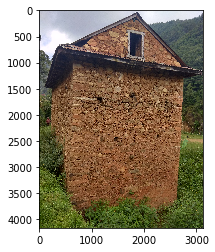

In [7]:
plt.imshow(cv2.cvtColor(list_img[8], cv2.COLOR_BGR2RGB))
plt.show()

In [21]:
feature_extractor = Feature_Extractor()

In [22]:
# Create a list called 'levels' to store number of floors for each building
levels = []
for i in range(n):
    n_level = feature_extractor.count_level(list_img[i])
    levels.append(n_level)

In [26]:
Counter(levels)

Counter({1: 192})

In [27]:
# Create a list called 'openings' to store number of openings
openings = []
for i in range(n):
    openings.append(feature_extractor.count_openings(list_img[i]))

In [28]:
Counter(openings)

Counter({40: 1,
         5904: 1,
         461: 2,
         145: 2,
         299: 1,
         715: 1,
         23: 1,
         327: 1,
         574: 1,
         687: 1,
         286: 1,
         584: 1,
         325: 1,
         4308: 1,
         148: 2,
         157: 1,
         80: 1,
         278: 2,
         115: 1,
         4742: 1,
         4772: 1,
         3273: 1,
         360: 1,
         189: 1,
         1447: 1,
         8555: 1,
         5230: 1,
         14349: 1,
         95: 1,
         1729: 1,
         1295: 1,
         436: 1,
         15: 1,
         280: 1,
         415: 1,
         5233: 1,
         726: 1,
         4088: 1,
         2478: 1,
         2332: 1,
         2791: 1,
         1288: 2,
         644: 1,
         1093: 1,
         5873: 1,
         880: 1,
         328: 1,
         297: 1,
         513: 1,
         350: 1,
         4045: 1,
         985: 1,
         866: 1,
         645: 1,
         84: 1,
         409: 1,
         2647: 1,
         2073: 

In [29]:
# Create a list called 'fraction_widths' to store proportion of sum of all windows' widths (without overlap), (on all floors) 
# to the overall width of building
fraction_widths = []
for i in range(n):
    fraction_widths.append(feature_extractor.fraction_width(list_img[i]))

In [30]:
fraction_widths[8]

0.2419871794871795

In [32]:
# Create a list called 'avg_fraction_widths' to store proportion of average of all windows' widths (over all floors) 
# to the overall width of building
avg_fraction_widths = []
for i in range(n):
    avg_fraction_widths.append(feature_extractor.avg_fraction_width(list_img[i]))

In [33]:
avg_fraction_widths[8]

0.3458333333333333

In [35]:
# Create a list called 'fraction_heights' to store proportion of sum of all windows' heights (without overlap), on all floors 
# to the overall height of building
fraction_heights = []
for i in range(n):
    fraction_heights.append(feature_extractor.fraction_height(list_img[i]))

In [36]:
fraction_heights[8]

0.14807692307692308

In [37]:
# Create a list called 'aggregate_fraction_heights' to store proportion of sum of all windows' heights (on all floors) 
# to the overall height of building
aggregate_fraction_heights = []
for i in range(n):
    aggregate_fraction_heights.append(feature_extractor.aggregate_fraction_height(list_img[i]))

In [ ]:
aggregate_fraction_heights[8]

In [ ]:
# Create a list called 'img_widths' to store the pixel widths of all images
img_widths = []
for i in range(n):
    img_widths.append(feature_extractor.img_width(list_img[i]))

In [ ]:
Counter(img_widths)

In [ ]:
# Create a list called 'img_heights' to store the pixel widths of all images
img_heights = []
for i in range(n):
    img_heights.append(feature_extractor.img_height(list_img[i]))

In [ ]:
counter(img_heights)